# Tuning Empirical Gaussian FLORIS Model to SCADA Using Interpolation and Mathematical Optimization

In this notebook, the Empirical Gaussian FLORIS Model (emgauss) will be tuned to align with SCADA data using an interpolation/mathematical optimization technique that determines the parameter value(s) that minimize the error (mean squared error) between SCADA and FLORIS energy ratios. 

The parameters of interest in this tuning exercise are 'wake_expansion_rates' (1st expansion rate) and 'horizontal_deflection_gain_D'. These parameters are associated with the following operating scenarios:

wake_expansion_rates => basline case

horizontal_deflection_gain_D => wake steering case

## Import Relevant Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from floris.tools import FlorisInterface

from flasc.model_tuning.floris_tuner import FlorisTuner


ModuleNotFoundError: No module named 'flasc.model_estimation.floris_tuner'

In [ ]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

## Load and Inspect SCADA

Load pre-processed SCADA data with power curve fiiltering and northing calibration applied, and inspect the data.

In [ ]:
def load_scada(scada_path: str):
    """
    Load SCADA

    Args:
        scada_path (:py:obj:`str`): Path to load SCADA from.

    Returns:
        df_scada (:py:obj:`pd.DataFrame`): SCADA data.
    """
    
    df_scada = pd.read_feather(scada_path)

    # If 'downsample' is True, downsample SCADA data to [x] minute averages to speed things up
    # if downsample:
    #     cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    #     df_scada = fto.df_downsample(
    #         df_scada,
    #         cols_angular=cols_angular,
    #         window_width=td(seconds=600),
    #     )

    return df_scada

In [ ]:
# Specify SCADA file path and load the dataframe
scada_path = os.path.join(Path.cwd(), "postprocessed", "df_scada_data_60s_filtered_and_northing_calibrated.ftr")
df_scada = load_scada(scada_path=scada_path)

In [ ]:
# Preview SCADA
df_scada.describe()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,wd_004,wd_005,wd_006,wind_vane_005,target_yaw_offset_005,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
count,134661,107990.000000,104834.000000,91602.000000,100703.000000,104591.000000,100064.000000,105990.000000,107990.000000,104834.000000,...,104591.000000,100064.000000,105990.000000,100064.000000,100064.000000,131704.000000,131699.000000,130266.000000,1.346610e+05,115694.000000
mean,2020-04-04 18:49:02.648873472,777.653931,722.490112,787.805054,650.537537,708.335510,711.493103,734.078857,7.992405,7.442919,...,148.641602,152.192139,146.140839,0.822919,0.783870,147.975891,7.286751,639.086548,1.100000e-01,147.147975
min,2020-02-17 16:30:00,0.001000,0.003000,0.002000,0.009000,0.007000,0.032000,0.000000,1.483000,2.746000,...,0.022003,0.009750,0.192000,-43.056999,-0.000000,0.005936,0.101000,-45.498859,1.100000e-01,0.035300
25%,2020-03-12 01:51:00,235.364014,214.135498,246.605499,193.113007,205.125000,174.702759,219.265747,6.128000,5.578000,...,50.771000,52.388748,49.512001,-5.913000,-0.000000,47.813656,5.121595,98.970131,1.100000e-01,47.626443
50%,2020-04-04 10:58:00,571.507019,528.515503,592.422974,467.604004,501.115997,508.388489,540.299988,7.448000,7.027000,...,129.255997,159.308258,135.268494,0.185000,-0.000000,138.522034,7.423318,422.463989,1.100000e-01,136.650682
75%,2020-04-27 20:03:00,1238.221802,1120.502441,1242.167236,997.825989,1085.923462,1133.235962,1132.259033,9.587000,8.945000,...,235.914993,234.888504,232.869751,6.917000,0.000000,235.295441,9.361652,1049.996338,1.100000e-01,233.836438
max,2020-05-24 23:59:00,2064.696045,2065.387939,2051.489990,2062.987061,2063.420898,2078.750977,2076.895996,20.851999,21.240999,...,359.997009,359.980743,359.989014,59.181999,20.000000,359.991791,20.422459,2147.802246,1.100000e-01,359.957791
std,NaN,639.254761,609.922241,636.098022,560.755066,612.281738,624.734497,617.581970,2.547888,2.501712,...,99.421783,97.336273,97.354767,10.042883,3.210437,101.749596,3.104111,629.421387,8.326704e-17,100.092758


In [ ]:
df_scada.head()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,is_operation_normal_005,is_operation_normal_006,wind_vane_005,target_yaw_offset_005,control_mode,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
0,2020-02-17 16:30:00,2023.746948,2045.376953,2031.724976,NaN,2028.063965,2032.461060,1983.390991,13.066,12.337,...,True,True,3.299,-0.0,baseline,251.041672,12.582482,2021.060059,0.11,251.377068
1,2020-02-17 16:31:00,1959.036011,2050.572998,2034.890991,NaN,2017.777954,1943.764038,2046.568970,12.091,13.057,...,True,True,1.825,-0.0,baseline,251.282684,12.823891,2022.767212,0.11,251.485048
2,2020-02-17 16:32:00,2053.658936,2032.191040,2011.870972,NaN,NaN,2052.092041,2039.948975,13.381,12.213,...,True,True,8.314,-0.0,baseline,252.874130,12.859400,2034.417480,0.11,253.473037
3,2020-02-17 16:33:00,2044.296997,2060.478027,1995.057983,NaN,NaN,2008.868042,2058.000000,14.345,13.141,...,True,True,2.384,-0.0,baseline,251.341553,13.426766,2039.458252,0.11,251.104001
4,2020-02-17 16:34:00,2058.281006,2042.703003,2031.723999,NaN,NaN,1819.896973,2059.760010,14.338,12.723,...,True,True,17.271,-0.0,baseline,253.343018,13.225105,2048.116943,0.11,255.679234


In [ ]:
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

## Prepare SCADA for Computing Energy Ratios (Baseline + Wake Steering Cases)

The energy ratio class as presently implemented requires explicit identification of the dataframe of the reference wind direction, wind speed, and power columns: "wd," "ws," and "pow_ref." Here, these will be set equal to the reference variables used in the SMARTEOLE wake steering experiment, which was computed in "02_download_and_format_dataset.ipynb".

In [ ]:
# Specify offsets
start_of_offset = 200 # deg
end_of_offset = 240 # deg

In [ ]:
# Limit SCADA to this region
df_scada = df_scada[(df_scada.wd_smarteole > (start_of_offset - 20)) &
                    (df_scada.wd_smarteole < (end_of_offset + 20))]

In [ ]:
# Assign wd, ws and pow ref and subset SCADA based on reference variables used in the SMARTEOLE wake steering experiment (TODO reference the experiment)
df_scada = (df_scada
    .assign(
        wd = lambda df_: df_['wd_smarteole'],
        ws = lambda df_: df_['ws_smarteole'],
        pow_ref = lambda df_: df_['pow_ref_smarteole']
    )
)

In [ ]:
# Split SCADA into baseline and wake steeering (controlled)
df_scada_baseline = df_scada[df_scada.control_mode=='baseline']
df_scada_controlled = df_scada[df_scada.control_mode=='controlled']

## Load FLORIS model

Specify the path of the Empirical Gaussian FLORIS Model (emgauss) YAML file. Instantiate the FLORIS model using this file. 

In [ ]:
# Specify emgauss model
wake_model = 'emgauss'

# Specify emgauss yaml file
yaml = os.path.join('floris_input', 'emgauss.yaml')

# Instantiate FLORIS model object using emgauss yaml
fi = FlorisInterface(yaml)

# Define D
D = fi.floris.farm.rotor_diameters[0]

## Prepare FLORIS for Tuning (Baseline Case)

Using the FlorisTuner class, generate and inspect the associated dataframe for FLORIS that will be used for the energy ratio comparision with SCADA. 

In [ ]:
# Instantiate a FLORIS model tuner object
floris_tuner_baseline = FlorisTuner(fi=fi,
                                    df_scada=df_scada_baseline, 
                                    num_turbines=7, 
                                    test_turbines=[4]) 

## Tune "wake_expansion_rates" Using the Interpolation/Mathematical Optimization Technique 

The parameter of interest in the baseline case is "wake_expansion_rates". For now, no breakpoints will be assumed and thus only the 1st wake expansion rate (wake_expansion_rates[0]) will be tuned.

This tuning process is comprised of the following steps:
1. Specify a discrete range of values (initial YAML to N) to set wake_expansion_rates[0] to.

2. Generate the FLORIS energy ratios for this range of wake_expansion_rates[0] and compare to the SCADA energy ratios.

3. Calculate the error (mean squared error) between the FLORIS and SCADA energy ratios.

4. Interpolate a function to represent the error curve. 

5. Solve the optimization problem of minimizing the error curve.

6. Set wake_expansion_rates[0] equal to the x value of the solution to the optimization problem.

In [ ]:
# Specify a range of wake expansion rates (assuming no breakpoints) values
wake_expansion_rates = np.linspace(start=0.01, 
                                   stop=0.2)

## Visualize Results

Plot the true error, predicted error (error curve), local minimum of the true error and the minimum determined by the optimization solution

Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes

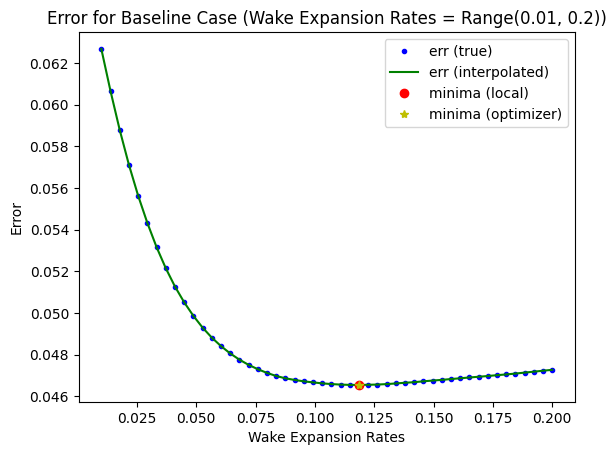

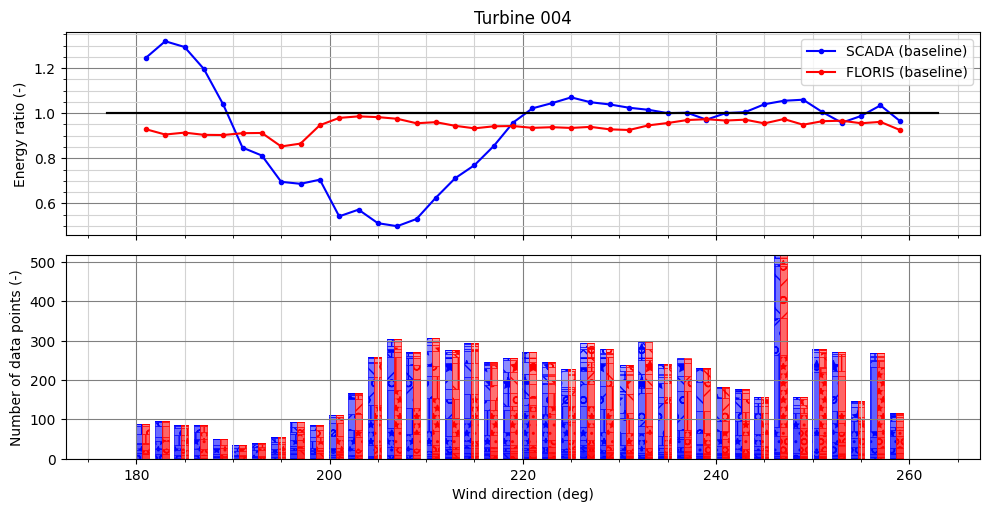

In [ ]:
# Determine the optimal value for wake expansion rates
fi_baseline_tuned, optimal_wake_expansion_rate, optimal_baseline_err, baseline_err_curve, true_baseline_err = floris_tuner_baseline.tune_floris(case='baseline',
                                                                                                                             pow_ref_columns=[0, 1, 2, 6],
                                                                                                                             param_name='Wake Expansion Rates',
                                                                                                                             param_values=wake_expansion_rates,
                                                                                                                             wd_step=2.0,
                                                                                                                             ws_step=1.0,
                                                                                                                             wd_bin_width=2.0,
                                                                                                                             verbose=False,
                                                                                                                             plot_err=True,
                                                                                                                             plot_energy_ratios=True)  

## Prepare FLORIS for Tuning (Wake Steering Case)

Using the FlorisTuner class, generate and inspect the associated dataframe for FLORIS that will be used for the energy ratio comparision with SCADA. 

In [ ]:
# Instantiate a FLORIS model tuner object
floris_tuner_controlled = FlorisTuner(fi=fi,
                                      df_scada=df_scada_controlled, 
                                      num_turbines=7, 
                                      test_turbines=[5],
                                      steered_turbine=5,
                                      yaw=df_scada_controlled.target_yaw_offset_005.values) 

## Tune "horizontal_deflection_gain_D" Using the Interpolation/Mathematical Optimization Technique 

The parameter of interest in the wake steering case is "horizontal_deflection_gain_D".

This tuning process is comprised of the following steps:

1. Specify a discrete range of values (initial YAML to N) to set horizontal_deflection_gain_D to.

2. Generate the FLORIS energy ratios for this range of horizontal_deflection_gain_D and compare to the SCADA energy ratios.

3. Calculate the error (mean squared error) between the FLORIS and SCADA energy ratios.

4. Interpolate a function to represent the error curve. 

5. Solve the optimization problem of minimizing the error curve.

6. Set horizontal_deflection_gain_D equal to the x value of the solution to the optimization problem.

In [ ]:
# Specify a range of horizontal deflection values
horizontal_deflection_gain_D = np.linspace(start=0.0, 
                                           stop=2.0)

Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes differ in wd and ws. Rebalancing.
Dataframes

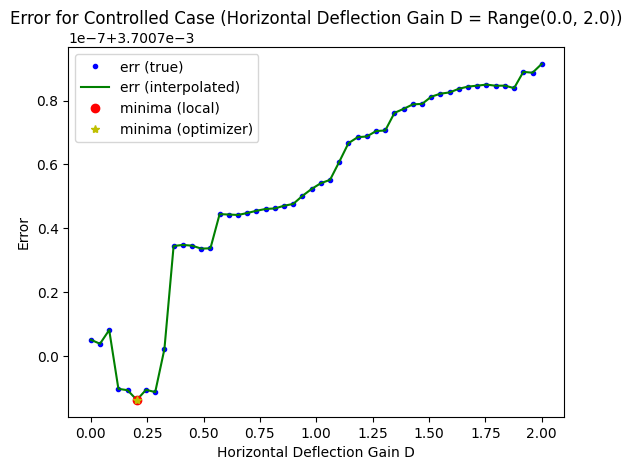

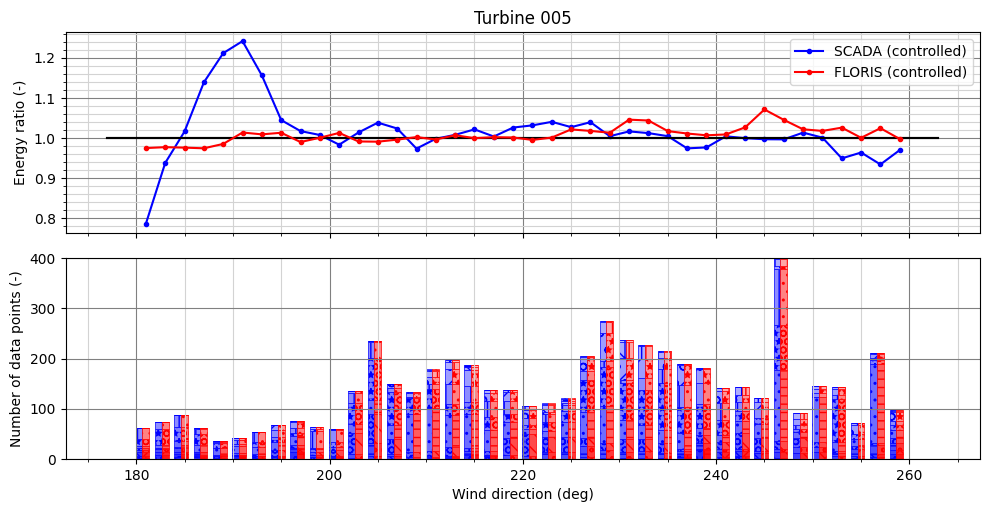

In [ ]:
# Determine the optimal value for horizontal deflection gain
fi_controlled_tuned, optimal_horizontal_deflection_gain_D, optimal_controlled_err, controlled_err_curve, true_controlled_err = floris_tuner_controlled.tune_floris(case='controlled',
                                                                                                                                                                   pow_ref_columns=[0, 1, 2, 6],
                                                                                                                                                                   param_name='Horizontal Deflection Gain D',
                                                                                                                                                                   param_values=horizontal_deflection_gain_D,
                                                                                                                                                                   wd_step=2.0,
                                                                                                                                                                   ws_step=1.0,
                                                                                                                                                                   wd_bin_width=2.0,
                                                                                                                                                                   verbose=False,
                                                                                                                                                                   plot_err=True,
                                                                                                                                                                   plot_energy_ratios=True)  

## Save Tuned FLORIS Parameters to a YAML File

 Output the parameters of the tuned FLORIS models to YAML files for future use.

In [ ]:
# Specify file paths to write the YAML files to
baseline_filepath = os.path.join(Path.cwd(), 'floris_input', 'tuned_baseline_emgauss.yaml')
controlled_filepath = os.path.join(Path.cwd(), 'floris_input', 'tuned_controlled_emgauss.yaml')

In [ ]:
# Write the YAML files
floris_tuner_baseline.write_yaml(baseline_filepath)
floris_tuner_controlled.write_yaml(controlled_filepath)

Writing new FLORIS YAML file to `/Users/eeyeson/Documents/flasc/examples_smarteole/floris_input/tuned_baseline_emgauss.yaml`...
Finished writing FLORIS YAML file.
Writing new FLORIS YAML file to `/Users/eeyeson/Documents/flasc/examples_smarteole/floris_input/tuned_controlled_emgauss.yaml`...
Finished writing FLORIS YAML file.
